In [1]:
from torch import optim
import os
import torchvision.utils as vutils
import numpy as np
from torchvision import datasets
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F


In [2]:
# Arguments
BATCH_SIZE = 256
Z_DIM = 10
LABEL_EMBED_SIZE = 5
NUM_CLASSES = 10
IMGS_TO_DISPLAY_PER_CLASS = 20
LOAD_MODEL = False

DB = 'FashionMNIST'  # SVHN | MNIST | FashionMNIST | USPS

if DB == 'MNIST' or DB == 'FashionMNIST':
    CHANNELS = 1
    EPOCHS = 50
elif DB == 'USPS':
    CHANNELS = 1
    EPOCHS = 100
elif DB == 'SVHN':
    CHANNELS = 3
    EPOCHS = 100
else:
    print("Incorrect dataset")
    exit(0)

In [3]:
# Directories for storing data, model and output samples
db_path = os.path.join('./data', DB)
if not os.path.exists(db_path):
    os.makedirs(db_path)
model_path = os.path.join('./model', DB)
if not os.path.exists(model_path):
    os.makedirs(model_path)
samples_path = os.path.join('./samples', DB)
if not os.path.exists(samples_path):
    os.makedirs(samples_path)

In [5]:
# Data loader
transform = transforms.Compose([transforms.Resize([32, 32]),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])])

if DB == 'MNIST':
    dataset = datasets.MNIST(db_path, train=True, download=True, transform=transform)
elif DB == 'FashionMNIST':
    dataset = datasets.FashionMNIST(db_path, train=True, download=True, transform=transform)
elif DB == 'USPS':
    dataset = datasets.USPS(db_path, train=True, download=True, transform=transform)
elif DB == 'SVHN':
    dataset = datasets.SVHN(db_path, split='train', download=True, transform=transform)
else:
    print("Incorrect DB")
    exit(0)

data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4,
                                          drop_last=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
# Method for storing generated images
def generate_imgs(z, fixed_label, epoch=0):
    gen.eval()
    fake_imgs = gen(z, fixed_label)
    fake_imgs = (fake_imgs + 1) / 2
    fake_imgs_ = vutils.make_grid(fake_imgs, normalize=False, nrow=IMGS_TO_DISPLAY_PER_CLASS)
    vutils.save_image(fake_imgs_, os.path.join(samples_path, 'sample_' + str(epoch) + '.png'))


In [7]:
# Networks
def conv_block(c_in, c_out, k_size=4, stride=2, pad=1, use_bn=True, transpose=False):
    module = []
    if transpose:
        module.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=not use_bn))
    else:
        module.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=not use_bn))
    if use_bn:
        module.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*module)


In [8]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, num_classes=10, label_embed_size=5, channels=3, conv_dim=64):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, label_embed_size)
        self.tconv1 = conv_block(z_dim + label_embed_size, conv_dim * 4, pad=0, transpose=True)
        self.tconv2 = conv_block(conv_dim * 4, conv_dim * 2, transpose=True)
        self.tconv3 = conv_block(conv_dim * 2, conv_dim, transpose=True)
        self.tconv4 = conv_block(conv_dim, channels, transpose=True, use_bn=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight, 0.0, 0.02)

            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x, label):
        x = x.reshape([x.shape[0], -1, 1, 1])
        label_embed = self.label_embedding(label)
        label_embed = label_embed.reshape([label_embed.shape[0], -1, 1, 1])
        x = torch.cat((x, label_embed), dim=1)
        x = F.relu(self.tconv1(x))
        x = F.relu(self.tconv2(x))
        x = F.relu(self.tconv3(x))
        x = torch.tanh(self.tconv4(x))
        return x


In [9]:
class Discriminator(nn.Module):
    def __init__(self, num_classes=10, channels=3, conv_dim=64):
        super(Discriminator, self).__init__()
        self.image_size = 32
        self.label_embedding = nn.Embedding(num_classes, self.image_size*self.image_size)
        self.conv1 = conv_block(channels + 1, conv_dim, use_bn=False)
        self.conv2 = conv_block(conv_dim, conv_dim * 2)
        self.conv3 = conv_block(conv_dim * 2, conv_dim * 4)
        self.conv4 = conv_block(conv_dim * 4, 1, k_size=4, stride=1, pad=0, use_bn=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0.0, 0.02)

            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x, label):
        alpha = 0.2
        label_embed = self.label_embedding(label)
        label_embed = label_embed.reshape([label_embed.shape[0], 1, self.image_size, self.image_size])
        x = torch.cat((x, label_embed), dim=1)
        x = F.leaky_relu(self.conv1(x), alpha)
        x = F.leaky_relu(self.conv2(x), alpha)
        x = F.leaky_relu(self.conv3(x), alpha)
        x = torch.sigmoid(self.conv4(x))
        return x.squeeze()


In [10]:
gen = Generator(z_dim=Z_DIM, num_classes=NUM_CLASSES, label_embed_size=LABEL_EMBED_SIZE, channels=CHANNELS)
dis = Discriminator(num_classes=NUM_CLASSES, channels=CHANNELS)


In [11]:
# Load previous model   
if LOAD_MODEL:
    gen.load_state_dict(torch.load(os.path.join(model_path, 'gen.pkl')))
    dis.load_state_dict(torch.load(os.path.join(model_path, 'dis.pkl')))


In [12]:
# Model Summary
print("------------------Generator------------------")
print(gen)
print("------------------Discriminator------------------")
print(dis)


------------------Generator------------------
Generator(
  (label_embedding): Embedding(10, 5)
  (tconv1): Sequential(
    (0): ConvTranspose2d(15, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv4): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)
------------------Discriminator------------------
Discriminator(
  (label_embedding): Embedding(10, 1024)
  (conv1): Sequential(
    (0): Conv2d(2, 64, kernel_size

In [ ]:
# Define Optimizers
g_opt = optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-5)
d_opt = optim.Adam(dis.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-5)

# Loss functions
loss_fn = nn.BCELoss()

# Fix images for viz
fixed_z = torch.randn(1, IMGS_TO_DISPLAY_PER_CLASS, Z_DIM)
fixed_z = torch.repeat_interleave(fixed_z, NUM_CLASSES, 0).reshape(-1, Z_DIM)
fixed_label = torch.arange(0, NUM_CLASSES)
fixed_label = torch.repeat_interleave(fixed_label, IMGS_TO_DISPLAY_PER_CLASS)

# Labels
real_label = torch.ones(BATCH_SIZE)
fake_label = torch.zeros(BATCH_SIZE)

# GPU Compatibility
is_cuda = torch.cuda.is_available()
if is_cuda:
    gen, dis = gen.cuda(), dis.cuda()
    real_label, fake_label = real_label.cuda(), fake_label.cuda()
    fixed_z, fixed_label = fixed_z.cuda(), fixed_label.cuda()

total_iters = 0
max_iter = len(data_loader)


In [21]:
fixed_label

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0')

In [18]:
# Training
for epoch in range(EPOCHS):
    gen.train()
    dis.train()

    for i, data in enumerate(data_loader):

        total_iters += 1

        # Loading data
        x_real, x_label = data
        z_fake = torch.randn(BATCH_SIZE, Z_DIM)

        if is_cuda:
            x_real = x_real.cuda()
            x_label = x_label.cuda()
            z_fake = z_fake.cuda()

        # Generate fake data
        x_fake = gen(z_fake, x_label)

        # Train Discriminator
        fake_out = dis(x_fake.detach(), x_label)
        real_out = dis(x_real.detach(), x_label)
        d_loss = (loss_fn(fake_out, fake_label) + loss_fn(real_out, real_label)) / 2

        d_opt.zero_grad()
        d_loss.backward()
        d_opt.step()

        # Train Generator
        fake_out = dis(x_fake, x_label)
        g_loss = loss_fn(fake_out, real_label)

        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()

        if i % 50 == 0:
            print("Epoch: " + str(epoch + 1) + "/" + str(EPOCHS)
                  + "\titer: " + str(i) + "/" + str(max_iter)
                  + "\ttotal_iters: " + str(total_iters)
                  + "\td_loss:" + str(round(d_loss.item(), 4))
                  + "\tg_loss:" + str(round(g_loss.item(), 4))
                  )

    if (epoch + 1) % 5 == 0:
        torch.save(gen.state_dict(), os.path.join(model_path, 'gen.pkl'))
        torch.save(dis.state_dict(), os.path.join(model_path, 'dis.pkl'))

        generate_imgs(fixed_z, fixed_label, epoch=epoch + 1)
generate_imgs(fixed_z, fixed_label)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1/50	iter: 0/234	total_iters: 1	d_loss:0.6848	g_loss:0.4062
Epoch: 1/50	iter: 50/234	total_iters: 51	d_loss:0.1798	g_loss:2.4652
Epoch: 1/50	iter: 100/234	total_iters: 101	d_loss:0.2921	g_loss:2.4259
Epoch: 1/50	iter: 150/234	total_iters: 151	d_loss:0.3587	g_loss:1.6338
Epoch: 1/50	iter: 200/234	total_iters: 201	d_loss:0.6388	g_loss:1.5124
Epoch: 2/50	iter: 0/234	total_iters: 235	d_loss:0.4715	g_loss:1.7532
Epoch: 2/50	iter: 50/234	total_iters: 285	d_loss:0.4269	g_loss:1.4565
Epoch: 2/50	iter: 100/234	total_iters: 335	d_loss:0.5273	g_loss:1.7601
Epoch: 2/50	iter: 150/234	total_iters: 385	d_loss:0.5894	g_loss:1.1096
Epoch: 2/50	iter: 200/234	total_iters: 435	d_loss:0.6445	g_loss:0.8945
Epoch: 3/50	iter: 0/234	total_iters: 469	d_loss:0.5219	g_loss:1.1323
Epoch: 3/50	iter: 50/234	total_iters: 519	d_loss:0.5143	g_loss:1.6622
Epoch: 3/50	iter: 100/234	total_iters: 569	d_loss:0.5056	g_loss:1.5433
Epoch: 3/50	iter: 150/234	total_iters: 619	d_loss:0.6021	g_loss:1.019
Epoch: 3/50	iter: 2

Label	Description

0	T-shirt/top

1	Trouser

2	Pullover

3	Dress

4	Coat

5	Sandal

6	Shirt

7	Sneaker

8	Bag

9	Ankle boot

**Inference**

In [106]:
classes=[2,9]
sample_no=99

In [124]:
no_classes=len(classes)
z_dim=10
images_per_class=50

In [126]:
fixed_z0 = torch.randn(1, images_per_class, z_dim)
fixed_z0 = torch.repeat_interleave(fixed_z0,no_classes, 0).reshape(-1, z_dim)
#fixed_label0 = torch.arange(0, NUM_CLASSES)
fixed_label0 = torch.tensor(classes)
fixed_label0 = torch.repeat_interleave(fixed_label0, images_per_class)

In [127]:
fixed_z0, fixed_label0 = fixed_z0.cuda(), fixed_label0.cuda()

In [128]:
fixed_z0.shape,fixed_label0.shape

(torch.Size([100, 10]), torch.Size([100]))

In [129]:
generate_imgs(fixed_z0, fixed_label0,sample_no)

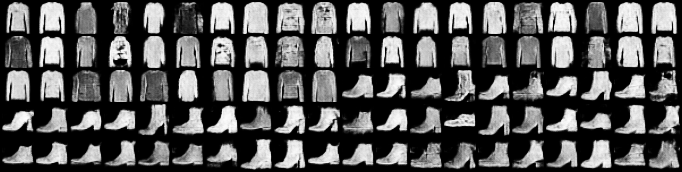

In [130]:
from google.colab.patches import cv2_imshow

import cv2
img = cv2.imread('/content/samples/MNIST/sample_'+str(sample_no)+'.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)